In [1]:
%load_ext watermark

In [2]:
%watermark -a Schmelling,Nicolas -u -d -v -p matplotlib,numpy,pandas,scipy,biopython

Schmelling,Nicolas 
Last updated: 26/11/2015 

CPython 2.7.9
IPython 3.0.0

matplotlib 1.4.3
numpy 1.9.2
pandas 0.15.2
scipy 0.15.1
biopython 1.65


---
Any comments and suggestions or questions?     
Please feel free to contact me via [twitter](https://twitter.com/bio_mediocre) or [email](mailto:schmelli@msu.edu).

---

#Distribution of circadian clock proteins#
---

In the previous [IPython notebook](1_KaiABC_BLAST_DataCollectionProcessing.ipynb) we collected all sorts of data about BLAST results and metrics, and additional information about the organism and protein itself. In the following the identity of sequence similar protein identified within the reciprocal BLAST.

---

<a id='Content'></a>
-----

#Content#
---

| [16S RNA Phylogeny](#phylogeny) | [Preprocessing](#code) | [Heatmap of protein identities](#heatmap) | [Heatmap with number of circadian clock protein copies](#cyano_count) |

---

In [3]:
from Bio import SeqIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.gridspec as gridspec
from scipy.spatial.distance import pdist,squareform
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy
import re
import csv
%pylab inline

Populating the interactive namespace from numpy and matplotlib


<a id='phylogeny'></a>
-----

###16S RNA Phylogeny###

---

A 16S RNA phylogentic tree was build with CLUSTAL Omega on the [EMBL Server](http://www.ebi.ac.uk/Tools/msa/clustalo/) and python. The 16S RNA sequences were used for a multiple alingment by CLUSTAL Omega. This produced a distance matrix, which was used to create a phylogenetic tree with python. 

---

In [4]:
# All 228 genera, which contain a KaiC homolog and remain after further filtering
all_orgs = ['Acaryochloris', 'Anabaena', 'Aphanizomenon', 'Aphanocapsa', 'Arthrospira', 'Calothrix', 'Chamaesiphon',
            'Coleofasciculus', 'Crinalium', 'Crocosphaera', 'Cyanobacterium', 'Cyanobium', 'Cyanothece',
            'Cylindrospermum', 'Dactylococcopsis', 'Fischerella', 'Geitlerinema', 'Gloeocapsa', 'Halothece',
            'Hassallia', 'Leptolyngbya', 'Lyngbya', 'Microcoleus', 'Microcystis', 'Moorea', 'Nodularia', 'Nostoc',
            'Oscillatoria', 'Planktothrix', 'Pleurocapsa', 'Pseudanabaena', 'Rivularia', 'Scytonema', 'Stanieria',
            'Synechococcus', 'Synechocystis', 'Thermosynechococcus', 'Trichodesmium', 'Acidocella', 'Alkalilimnicola',
            'Allochromatium', 'Arcticibacter', 'Asticcacaulis', 'Bradyrhizobium', 'Chitinophaga', 'Chloroflexus', 
            'Chloroherpeton', 'Chroococcidiopsis', 'Chthoniobacter', 'Desulfonatronospira', 'Ectothiorhodospira', 
            'Fibrella', 'Fimbriimonas', 'Flavobacterium', 'Geobacter', 'Haliangium', 'Halorhodospira', 'Hymenobacter', 
            'Kutzneria', 'Legionella', 'Mesorhizobium', 'Methanocella', 'Methanoregula', 'Methanosarcina', 
            'Methanothermobacter', 'Methylobacterium', 'Methylomicrobium', 'Niastella', 'Pedobacter', 'Phycisphaera', 
            'Prochlorococcus', 'Rhizobium', 'Rhodobacter', 'Rhodopirellula', 'Rhodopseudomonas', 'Rhodospirillum', 
            'Rhodovulum', 'Roseiflexus', 'Rubidibacter', 'Rubrivivax', 'Smithella', 'Spirosoma', 'Sporomusa', 
            'Streptomyces', 'Thiocapsa', 'Thioflavicoccus', 'Thiorhodovibrio', 'Acidianus', 'Acidithiobacillus',  
            'Aciduliprofundum', 'Actinoplanes', 'Aeropyrum', 'Agrobacterium', 'Anaeromyxobacter', 'Archaeoglobus', 
            'Aurantimonas', 'Azospirillum', 'Blastopirellula', 'Brevundimonas', 'Burkholderia', 'Caenispirillum', 
            'Caldicellulosiruptor', 'Caldivirga', 'Carboxydothermus', 'Caulobacter', 'Chlorogloeopsis', 'Chondromyces',
            'Chromohalobacter', 'Corallococcus', 'Cystobacter', 'Desulfobacter', 'Desulfomicrobium', 
            'Desulfosporosinus', 'Desulfotomaculum', 'Desulfurococcus', 'Ferroglobus', 'Fervidicoccus', 'Geoglobus', 
            'Gloeobacter', 'Granulicella', 'Haladaptatus', 'Halalkalicoccus', 'Halanaerobium', 'Halarchaeum', 
            'Haloarcula', 'Halobacterium', 'Halobiforma', 'Haloferax', 'Halogeometricum', 'Halomicrobium', 'Halomonas',
            'Halonotius', 'Halopiger', 'Halorhabdus', 'Halorubrum', 'Halosarcina', 'Halosimplex', 'Haloterrigena', 
            'Halovivax', 'Herbaspirillum', 'Herminiimonas', 'Hoeflea', 'Hyalangium', 'Hydrogenobacter', 
            'Hydrogenophaga', 'Hyperthermus', 'Ignicoccus', 'Ignisphaera', 'Janthinobacterium', 'Loktanella', 
            'Lysobacter', 'Magnetospirillum', 'Massilia', 'Metallosphaera', 'Methanobacterium', 'Methanocaldococcus', 
            'Methanococcoides', 'Methanoculleus', 'Methanohalobium', 'Methanohalophilus', 'Methanolobus', 
            'Methanoplanus', 'Methanopyrus', 'Methanosaeta', 'Methanospirillum', 'Methanothermococcus', 
            'Methanothermus', 'Methanotorris', 'Methylocella', 'Methylocystis', 'Methyloglobulus', 'Microvirga', 
            'Myxococcus', 'Nanoarchaeum', 'Natrialba', 'Natrinema', 'Natronobacterium', 'Natronococcus', 
            'Natronolimnobius', 'Natronomonas', 'Nitratiruptor', 'Nitrobacter', 'Nitrococcus', 'Nitrosococcus', 
            'Nitrosospira', 'Novosphingobium', 'Oceanibulbus', 'Oceanicola', 'Opitutus', 'Pelotomaculum', 
            'Phenylobacterium', 'Planctomyces', 'Polaromonas', 'Pseudomonas', 'Pseudoxanthomonas', 'Pyrobaculum', 
            'Pyrococcus', 'Pyrolobus', 'Ramlibacter', 'Rhodanobacter', 'Rhodomicrobium', 'Salinarchaeum', 
            'Sinorhizobium', 'Sorangium', 'Sphingobium', 'Sphingomonas', 'Spiribacter', 'Staphylothermus', 
            'Stenotrophomonas', 'Stigmatella', 'Sulfitobacter', 'Sulfolobus', 'Symbiobacterium', 'Terriglobus', 
            'Thermacetogenium', 'Thermoanaerobacter', 'Thermoanaerobaculum', 'Thermobaculum', 'Thermococcus', 
            'Thermofilum', 'Thermoproteus', 'Thermosipho', 'Thermosphaera', 'Thermotoga', 'Variovorax', 
            'Virgibacillus', 'Vulcanisaeta', 'Xanthomonas']

# Genera or other, that could filtered due to various reason:
# 1. Group: no genera or genera that were identified after detailed review to contain false annotated homologs. 
# 2. Group: no 16S RNA could be detected on NCBI.
# 3. Group: genera that were filtered out before.

not_found = ['Oscillatoriales', 'Gemmatimonadetes', 'Opitutaceae', 'Marine', 'Oxalobacteraceae',
             'Thermoplasmatales', 'Sulfolobales', 'Acetobacteraceae', 'nanoarchaeote', 'euryarchaeote',
             'Clostridiales', 'Burkholderiales', 'UI:98397326', 'Sphingomonas-like', 'Candidatus',
             'Sphingomonadaceae', 'Stigonematales', 'cyanobacterium', 'Caulobacteraceae', 'planctomycete',
             'Comamonadaceae', 'Oscillatoriophycideae', 'haloarchaeon', 'unclassified','gamma', 'Ricinus',
             'Bacillus', 'Bacillaceae', 'uncultured', 'Rhizobiales', 'delta', 'Solirubrobacterales',
             'Geodermatophilaceae', 'crenarchaeote', 'filamentous', 'bacterium', 'Acidobacteriaceae', 'archaeon',
             'halophilic', 'alpha', 'Aigarchaeota', 'Trichormus', 'Crenarchaeota', 'Acidobacteria', 'Nitrospirillum',
             'Dehalococcoidia', 'Rhodospirillales', 'Pseudoduganella',

             'Cylindrospermopsis', 'Neosynechococcus', 'Raphidiopsis', 'Richelia', 'Tolypothrix',
             'Xenococcus', 'Kirrobacter', 'Pedosphaera', 'Thermogladius', 'Neorhizobium', 'Kamptonema',
             'Geminocystis','Nodosilinea', 'Myxosarcina', 'Dolichospermum', 'Chitinivibrio', 'Mastigocladopsis',
             'Aerophobetes', 'Mastigocoleus', 'Microchaete', 'Nitrososphaera','Methanolacinia',
            
             'Aquifex', 'Ferroplasma', 'Methanocorpusculum',
             'Ferrovum', 'Methanosalsum', 'Arhodomonas', 'Halogranum', 'Palaeococcus', 'Geminicoccus','Desulfovibrio',
             'Methanomethylovorans', 'Thioalkalivibrio', 'Caldisphaera', 'Thermodesulfobacterium', 'Desulfatibacillum',
             'Simplicispira', 'Gemmata', 'Nevskia', 'Methylobacter', 'Ensifer', 'Luteibacter', 'Actinopolymorpha',
             'Zavarzinella', 'Gemmatimonas', 'Dyella', 'Segetibacter', 'Phyllobacterium', 'Pleomorphomonas',
             'Arenimonas', 'Arenibacter', 'Dongia', 'Solimonas', 'Paenibacillus', 'Skermanella', 'Uliginosibacterium',
             'Haloferula', 'Amorphus', 'Prochlorothrix', 'Thiocystis', 'Rhodovibrio', 'Edaphobacter', 'Inquilinus',
             'Salinarimonas', 'Pontibacter', 'Marinobacter', 'Verrucomicrobium', 'Sporichthya', 'Acidovorax',
             'Methanofollis', 'Methanosphaerula', 'Rubellimicrobium', 'Spirulina', 'Nitrosopumilus', 'Desulfonauticus',
             'Actinopolyspora', 'Saccharibacillus', 'Caldithrix', 'Streptosporangium', 'Alicyclobacillus',
             'Adhaeribacter', 'Dyadobacter', 'Microbispora', 'Marmoricola', 'Herbidospora', 'Oscillochloris',
             'Spirochaeta', 'Acidilobus', 'Thiomonas', 'Schlesneria', 'Parvularcula', 'Acidiphilium',
             'Marinobacterium', 'Salinisphaera', 'Lamprocystis', 'Desulfovirgula', 'Fodinicurvata', 'Desulfonatronum',
             'Deferrisoma', 'Azoarcus', 'Ktedonobacter', 'Bosea', 'Catenuloplanes', 'Solirubrobacter', 'Bordetella',
             'Hydrocarboniphaga', 'Allokutzneria', 'Methanomassiliicoccus', 'Duganella', 'Methylopila']

In [5]:
# Since the FASTA file contains only one 16S RNA sequence per genus, it is possible to simplify the header for each
# sequence, so that it only contains the genus name. This allows for easier identification in the phylogenetic tree,
# which was build with CLUSTAL Omega on the EMBL server. 
new_fasta = open('phylogen_tree_2_newnames.fasta','w')

for seq_record in SeqIO.parse('phylogen_tree_2.fasta', format='fasta'):
    
    new_fasta.write('>'+str(seq_record.description.split(' ',2)[1])+'\n')
    new_fasta.write(str(seq_record.seq)+'\n')
    
new_fasta.close()

In [6]:
# The function will transform a distance matrix from CLUSTAL Omega into a CSV file. 
# Input arguments: distance matrix, number of sequences, output file.
def parse_distance_matrix(file_name, line_len, out_file):

    raw_m = open(file_name,'r')

    m = []
    list_m = []

    count = 0
    
    # The following will do some wrangling of the input distance matrix in order to produce a clean CSV file.
    for line in raw_m.readlines()[1:]:
        new_line = line.replace('  ',',').replace(' ','')
        new_line_2 = re.sub(',,+', ',', new_line)
        for e in new_line_2.split(',', new_line_2.count(',')):
            if e:
                m.append(e.replace('\n',''))
                count += 1
                if count > line_len:
                    list_m.append(m)
                    count = 0
                    m = []

    with open(out_file, "wb") as f:
        writer = csv.writer(f)
        header = 'Organisms'+','*(line_len)+'\n'
        writer.writerow(header.split(',',line_len))
        writer.writerows(list_m)

In [7]:
parse_distance_matrix('Dist_Matrix_Phylogeny_NewNames.txt',228,
                      'Dist_Matrix_Phylogeny_NewNames.csv')

In [8]:
dist_df = pd.read_csv('Dist_Matrix_Phylogeny_NewNames.csv', index_col='Organisms')
dist_df.head()

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 219,Unnamed: 220,Unnamed: 221,Unnamed: 222,Unnamed: 223,Unnamed: 224,Unnamed: 225,Unnamed: 226,Unnamed: 227,
Organisms,,,,,,,,,,,,,,,,,,,,,
Nanoarchaeum,0.000,0.263,0.283,0.273,0.227,0.229,0.232,0.228,0.238,0.264,...,0.384,0.368,0.413,0.422,0.393,0.382,0.389,0.403,0.389,0.367
Sulfolobus,0.263,0.000,0.132,0.117,0.189,0.188,0.184,0.188,0.157,0.169,...,0.366,0.350,0.392,0.401,0.376,0.371,0.382,0.393,0.376,0.348
Acidianus,0.283,0.132,0.000,0.101,0.217,0.209,0.207,0.216,0.198,0.182,...,0.378,0.360,0.405,0.415,0.388,0.385,0.404,0.408,0.388,0.370
Metallosphaera,0.273,0.117,0.101,0.000,0.198,0.196,0.197,0.203,0.184,0.188,...,0.378,0.359,0.414,0.415,0.388,0.384,0.386,0.400,0.382,0.366
Caldivirga,0.227,0.189,0.217,0.198,0.000,0.077,0.101,0.101,0.137,0.188,...,0.381,0.362,0.396,0.392,0.390,0.378,0.381,0.387,0.379,0.359


In [9]:
# The linkage function returns a so-called linkage matrix. This linkage matrix consists of several rows where each 
# row consists of 1 merge. The first and second column denote the most dissimilar members in each cluster, and the 
# third row reports the distance between those members. The last column returns the count of members in the clusters.

row_clusters = linkage(pdist(dist_df, metric='euclidean'), method='complete')
pd.DataFrame(row_clusters, 
             columns=['row label 1', 'row label 2', 'distance', 'no. of items in clust.'],
             index=['cluster %d' %(i+1) for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,144,145,0.027568,2
cluster 2,184,185,0.051894,2
cluster 3,121,122,0.063945,2
cluster 4,41,42,0.066985,2
cluster 5,24,25,0.076824,2
cluster 6,80,81,0.078326,2
cluster 7,187,188,0.079183,2
cluster 8,166,167,0.082122,2
cluster 9,77,78,0.082735,2
cluster 10,207,208,0.084475,2


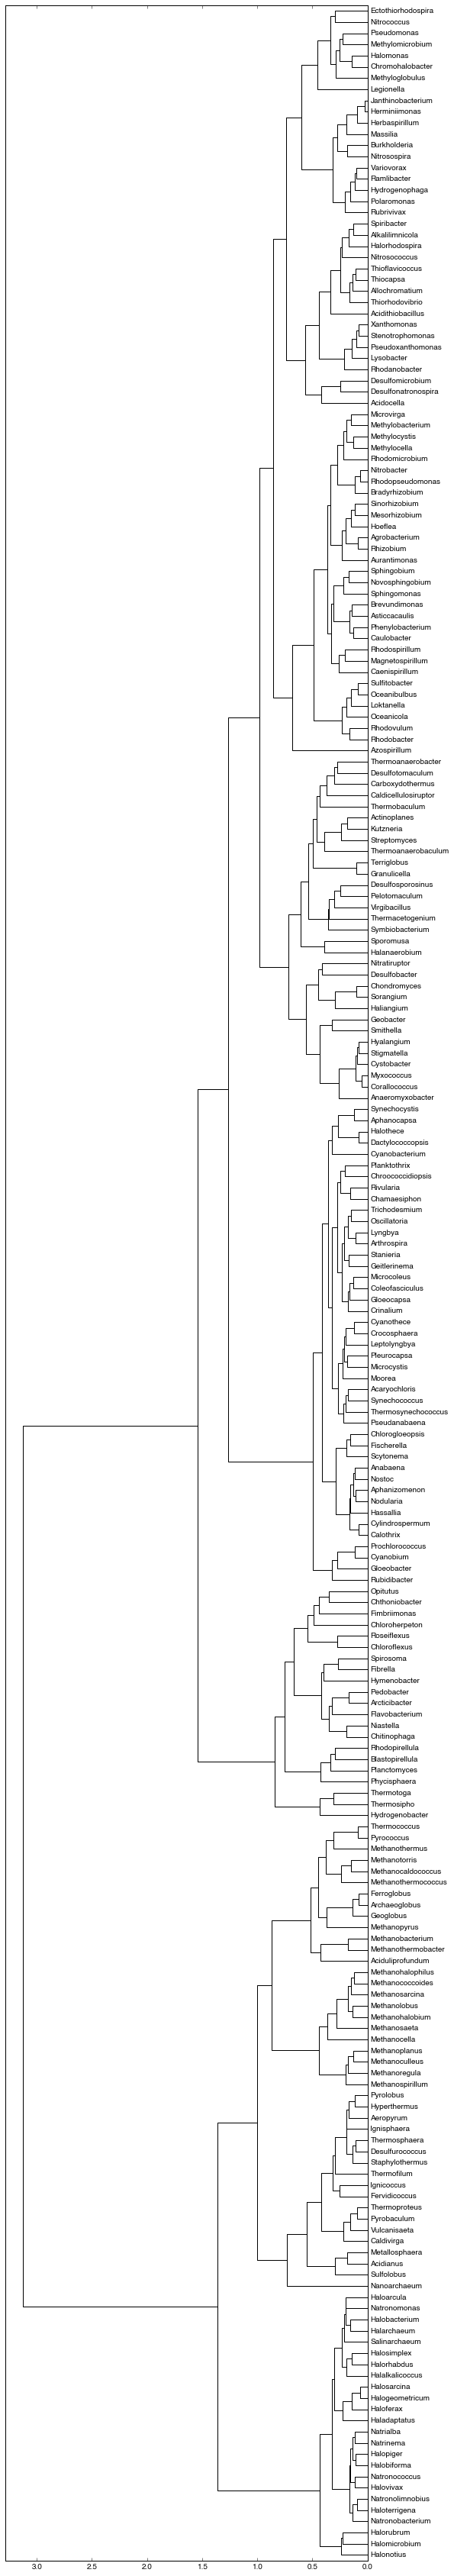

In [10]:
# Plot the phylogenetic tree
hierarchy.set_link_color_palette(['black'])

f = plt.figure(figsize=(8.5,60))

row_dendr = dendrogram(row_clusters, orientation='right', labels=dist_df.index,
                       color_threshold=np.inf,)

In [11]:
# Reorder data with respect to clustering
df = dist_df.ix[row_dendr['leaves'][::-1]]
index_lst = list(df.index)

[Back to Content](#Content)

<a id='code'></a>
-----

---
###Preprocessing###
---

Before the heatmap with the phylogenetic tree can be constructed, the input data needs to be processed.

1. Group the genera in the four groups according to their taxonomy. Groups are Cyanobacteria, Proteobacteria, Archaea, and Other Bacteria. Assign a numeric identifier to each group for coloring.
2. Calculate the identity mean for each protein and genus. Create a counter of each genus to record the number of individual organisms per genus.
3. Merge the the dataframes for each protein in a single datafram containing information about protein identity for each protein and genus.

---

In [12]:
pd.set_option('mode.chained_assignment',None)

In [13]:
# The function will group the genera in to four groups according to their taxonomy.
# Groups are Cyanobacteria, Proteobacteria, Archaea, and Other Bacteria. 
# The function will also assign a numeric identifier to each group for later coloring.
def categories_taxonomy(df):
    
    count = 0
    
    df['colormap'] = np.zeros(len(df.index))
    
    for i in list(df.taxonomy):
        if 'cyanobacteria' in str(i).lower():
            df.taxonomy[count] = 1
            df['colormap'][count] = 3
            count += 1
        elif 'proteobacteria' in str(i).lower():
            df.taxonomy[count] = 2
            df['colormap'][count] = 2
            count += 1
        elif 'archaea' in str(i).lower():
            df.taxonomy[count] = 3
            df['colormap'][count] = 1
            count += 1
        else:
            df.taxonomy[count] = 4
            df['colormap'][count] = 9
            count += 1
    
    return df

# The function will first call the function above and selects only cyanobacteria.
# Next a counter to record the number protein homologs of individual organisms will be created.
def create_count_df(path, prot_name, df_merge, how='left'):
    
    df = pd.read_csv(path)
    df = categories_taxonomy(df)
    df = df[df.taxonomy == 1]
    
    leng = prot_name + '_length'
    coun = prot_name + '_count'
    
    df = df[['query_name',leng]]
    df = df[df[leng] > 0].drop_duplicates()
    df[coun] = df.groupby(['query_name']).transform('count')
    df = df[['query_name',coun]].drop_duplicates()
    
    df_new = pd.merge(df_merge, df, how=how)
    
    return df_new

# The function will first call the function above and further calculate the identity mean for each protein and genus.
# Next it will create a counter of each genus to record the number of individual organisms per genus.
def prepare_df(df,prot):
    
    df = categories_taxonomy(df)
    df = df[['query_name','query_organism','taxonomy','colormap','identity','db_source']]
    df = df.groupby(['query_name','query_organism','taxonomy','colormap','db_source']).mean()
    df = df.reset_index()
    df['%s_count'%prot] = df.drop_duplicates(subset=['query_name'])[['query_name','query_organism']].groupby(['query_organism']).transform('count')
    df = df[['query_organism','taxonomy','colormap','identity','%s_count'%prot]]
    df.columns = ['query_organism', 'taxonomy','colormap','%s_identity'%prot,'%s_count'%prot]
    df = df.groupby(['query_organism','taxonomy']).mean()
    df = df.reset_index()
    
    return df

In [14]:
# Read the input data for each single protein and run the two function above.
kaiA = pd.read_csv('1._BLAST/Synechococcus/kaiA_all.csv')
kaiA = prepare_df(kaiA,'kaiA')

kaiB = pd.read_csv('1._BLAST/Synechococcus/kaiB_all.csv')
kaiB = prepare_df(kaiB,'kaiB')

kaiC = pd.read_csv('1._BLAST/Synechococcus/kaiC_all.csv')
kaiC = prepare_df(kaiC,'kaiC')

cpmA = pd.read_csv('1._BLAST/Synechococcus/cpmA_all.csv')
cpmA = prepare_df(cpmA,'cpmA')

ircA = pd.read_csv('1._BLAST/Synechococcus/ircA_all.csv')
ircA = prepare_df(ircA,'ircA')

pex = pd.read_csv('1._BLAST/Synechococcus/pex_all.csv')
pex = prepare_df(pex,'pex')

cdpA = pd.read_csv('1._BLAST/Synechococcus/cdpA_all.csv')
cdpA = prepare_df(cdpA,'cdpA')

ldpA = pd.read_csv('1._BLAST/Synechococcus/ldpA_all.csv')
ldpA = prepare_df(ldpA,'ldpA')

labA = pd.read_csv('1._BLAST/Synechococcus/labA_all.csv')
labA = prepare_df(labA,'labA')

lalA = pd.read_csv('1._BLAST/Synechococcus/lalA_all.csv')
lalA = prepare_df(lalA,'lalA')

cikA = pd.read_csv('1._BLAST/Synechococcus/cikA_all.csv')
cikA = prepare_df(cikA,'cikA')

sasA = pd.read_csv('1._BLAST/Synechococcus/sasA_all.csv')
sasA = prepare_df(sasA,'sasA')

nhtA = pd.read_csv('1._BLAST/Synechococcus/nhtA_all.csv')
nhtA = prepare_df(nhtA,'nhtA')

prkE = pd.read_csv('1._BLAST/Synechococcus/prkE_all.csv')
prkE = prepare_df(prkE,'prkE')

crm = pd.read_csv('1._BLAST/Synechococcus/crm_all.csv')
crm = prepare_df(crm,'crm')

rpaA = pd.read_csv('1._BLAST/Synechococcus/rpaA_all.csv')
rpaA = prepare_df(rpaA,'rpaA')

rpaB = pd.read_csv('1._BLAST/Synechococcus/rpaB_all.csv')
rpaB = prepare_df(rpaB,'rpaB')

In [15]:
kaiA.head()

,query_organism,taxonomy,colormap,kaiA_identity,kaiA_count
0,Acaryochloris,1,3,45.830012,1
1,Anabaena,1,3,48.318185,3
2,Aphanizomenon,1,3,49.504950,1
3,Aphanocapsa,1,3,42.244224,1
4,Arthrospira,1,3,43.076923,5


In [16]:
# Merge the dataframes of each protein into one dataframe.
# First merge the dataframes containing information about KaiA, KaiB and KaiC. Remove all genera not containing
# any KaiC homologs and further remove the genera that are not in the list of genera used for the phylogenetic tree
df_Sy7942 = pd.merge(kaiA,kaiB, how='outer')
df_Sy7942 = pd.merge(df_Sy7942, kaiC, how='outer')
df_Sy7942 = df_Sy7942.drop_duplicates()
df_Sy7942 = df_Sy7942[df_Sy7942.kaiC_identity.notnull()]
df_Sy7942 = df_Sy7942[df_Sy7942.query_organism.isin(index_lst)]

# Merge the KaiABC dataframe with the rest of the protein dataframes. Now only add the genera that are already in the 
# KaiABC dataframe, so that no new genera are added to the dataframe.
df_Sy7942 = pd.merge(df_Sy7942, cpmA, how='left')
df_Sy7942 = pd.merge(df_Sy7942, ircA, how='left')
df_Sy7942 = pd.merge(df_Sy7942, pex, how='left')
df_Sy7942 = pd.merge(df_Sy7942, cdpA, how='left')
df_Sy7942 = pd.merge(df_Sy7942, ldpA, how='left')
df_Sy7942 = pd.merge(df_Sy7942, labA, how='left')
df_Sy7942 = pd.merge(df_Sy7942, lalA, how='left')
df_Sy7942 = pd.merge(df_Sy7942, cikA, how='left')
df_Sy7942 = pd.merge(df_Sy7942, sasA, how='left')
df_Sy7942 = pd.merge(df_Sy7942, prkE, how='left')
df_Sy7942 = pd.merge(df_Sy7942, nhtA, how='left')
df_Sy7942 = pd.merge(df_Sy7942, crm, how='left')
df_Sy7942 = pd.merge(df_Sy7942, rpaA, how='left')
df_Sy7942 = pd.merge(df_Sy7942, rpaB, how='left')

# Sort the dataframe according to the phylogenetic tree.
sorterIndex = dict(zip(index_lst,range(len(index_lst))))
df_Sy7942['rank'] = df_Sy7942.query_organism.map(sorterIndex)
df_Sy7942 = df_Sy7942.sort(['rank'], ascending = [True])

# Reduce the number of columns down to the one needed for the heatmap.
df_Sy7942 = df_Sy7942[['query_organism','taxonomy','colormap','rank',
                       'kaiA_identity','kaiB_identity','kaiC_identity','pex_identity','ldpA_identity',
                       'nhtA_identity','prkE_identity','ircA_identity','cdpA_identity','cikA_identity',
                       'sasA_identity','labA_identity','lalA_identity','crm_identity',
                       'rpaA_identity','rpaB_identity','cpmA_identity','kaiC_count']]

df_Sy7942.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228 entries, 50 to 131
Data columns (total 22 columns):
query_organism    228 non-null object
taxonomy          228 non-null float64
colormap          228 non-null float64
rank              228 non-null int64
kaiA_identity     38 non-null float64
kaiB_identity     87 non-null float64
kaiC_identity     228 non-null float64
pex_identity      31 non-null float64
ldpA_identity     41 non-null float64
nhtA_identity     73 non-null float64
prkE_identity     82 non-null float64
ircA_identity     62 non-null float64
cdpA_identity     33 non-null float64
cikA_identity     87 non-null float64
sasA_identity     72 non-null float64
labA_identity     49 non-null float64
lalA_identity     107 non-null float64
crm_identity      51 non-null float64
rpaA_identity     46 non-null float64
rpaB_identity     85 non-null float64
cpmA_identity     115 non-null float64
kaiC_count        228 non-null float64
dtypes: float64(20), int64(1), object(1)
memory usage

In [17]:
kaiB1 = pd.read_csv('1._BLAST/Synechocystis/kaiB1_all.csv')
kaiB1 = prepare_df(kaiB1,'kaiB1')

kaiB2 = pd.read_csv('1._BLAST/Synechocystis/kaiB2_all.csv')
kaiB2 = prepare_df(kaiB2,'kaiB2')

kaiB3 = pd.read_csv('1._BLAST/Synechocystis/kaiB3_all.csv')
kaiB3 = prepare_df(kaiB3,'kaiB3')

kaiC1 = pd.read_csv('1._BLAST/Synechocystis/kaiC1_all.csv')
kaiC1 = prepare_df(kaiC1,'kaiC1')

kaiC2 = pd.read_csv('1._BLAST/Synechocystis/kaiC2_all.csv')
kaiC2 = prepare_df(kaiC2,'kaiC2')

kaiC3 = pd.read_csv('1._BLAST/Synechocystis/kaiC3_all.csv')
kaiC3 = prepare_df(kaiC3,'kaiC3')

In [18]:
df_Sy6803 = pd.merge(kaiB1,kaiB2, how='outer')
df_Sy6803 = pd.merge(df_Sy6803, kaiB3, how='outer')
df_Sy6803 = pd.merge(df_Sy6803, kaiC1, how='outer')
df_Sy6803 = pd.merge(df_Sy6803, kaiC2, how='outer')
df_Sy6803 = pd.merge(df_Sy6803, kaiC3, how='outer')
df_Sy6803 = df_Sy6803.drop_duplicates()
df_Sy6803 = df_Sy6803[df_Sy6803.query_organism.isin(index_lst)]

sorterIndex = dict(zip(df_Sy7942.query_organism,range(len(df_Sy7942.query_organism))))
df_Sy6803['rank'] = df_Sy6803.query_organism.map(sorterIndex)

df_Sy6803 = df_Sy6803.sort(['rank'], ascending = [True])

df_Sy6803 = df_Sy6803[['query_organism','taxonomy','colormap','rank',
                       'kaiB1_identity','kaiB2_identity','kaiB3_identity',
                       'kaiC1_identity','kaiC2_identity','kaiC3_identity']]

df_Sy6803.head(10)

,query_organism,taxonomy,colormap,rank,kaiB1_identity,kaiB2_identity,kaiB3_identity,kaiC1_identity,kaiC2_identity,kaiC3_identity
74,Ectothiorhodospira,2,2,0,NaN,46.067416,32.941176,NaN,38.095238,NaN
171,Nitrococcus,2,2,1,NaN,NaN,NaN,25.963489,NaN,NaN
175,Pseudomonas,2,2,2,NaN,NaN,NaN,26.550261,NaN,27.343387
106,Methylomicrobium,2,2,3,NaN,NaN,38.095238,NaN,38.490566,NaN
205,Halomonas,2,2,4,NaN,NaN,NaN,NaN,40.140518,24.430642
124,Chromohalobacter,2,2,5,NaN,NaN,NaN,24.949698,NaN,NaN
245,Methyloglobulus,2,2,6,NaN,NaN,NaN,NaN,NaN,28.542510
30,Legionella,2,2,7,41.666667,45.882353,42.449123,NaN,35.505720,NaN
152,Janthinobacterium,2,2,8,NaN,NaN,NaN,29.959189,NaN,29.035779
228,Herminiimonas,2,2,9,NaN,NaN,NaN,NaN,NaN,28.629032


[Back to Content](#Content)

<a id='heatmap'></a>
-----

---
###Heatmap with sequence identities###

---

After creating the dataframes, containing the identity information to the circadian clock proteins of _Synechococcus elongatus_ PCC 7942, and the KaiBC homolog of _Synechocystis sp._ PCC 6803, a heatmap is constructed.
A fast and actually really nice way to visualize informations from a spreadsheet is to create a [heatmap](en.wikipedia.org/wiki/Heat_map). Heatmaps are usually used to plot data, which are in a matrix format. Values are represented as colors.

I decided to use the identity rather than the e-value as values for the heatmap, b/c they vary not as much and are in a range from 0 to 100.

| [Heatmap with Phylogeny](#w/) | [Heatmap without Phylogeny](#w/o) | [Heatmap containing only cyanobacteria](#cyano) |

---

<a id='w/'></a>
-----

__Heatmap with Phylogeny__

---

In [19]:
# The function takes to dataframes and a file name and creates a heatmap with phylogeny and saves it.
def heatmap_phylo(df1,df2,name):
    
    f = plt.figure(figsize=(30,60))
    
    plots = gridspec.GridSpec(2,4,wspace=0.05,hspace=0.06,width_ratios=[2,3.5,0.6,1.25],
                              height_ratios=[1,0.01])
    
    hfont = {'fontname':'Arial'}
    
    matplotlib.rcParams['lines.linewidth'] = 3
    
    # Remove the plot frame lines. They are unnecessary chartjunk.
    def clean_axis(ax):
        for sp in ax.spines.values():
            sp.set_visible(False)
    
    ######## 1st Heatmap Synechococcus
    
    ax1 = f.add_subplot(plots[0,1])

    clean_axis(ax1)
    
    # Remove the tick marks; they are unnecessary with the tick lines we just plotted.  
    plt.tick_params(axis="both", which="both", bottom="off", top="off",
                    left="off", right="off", labeltop="on", labelbottom="on", 
                    labelleft="off", labelright="on")

    # Put the major ticks at the middle of each cell
    ax1.set_xticks(np.arange(df1.shape[1])+0.5, minor=False)
    ax1.set_yticks(np.arange(df1.shape[0])+0.5, minor=False)
    
    # Add axis labels
    ax1.set_xticklabels(['KaiA','KaiB','KaiC','Pex','LdpA','NhtA','PrkE','IrcA','CdpA','CikA','SasA','LabA','LalA','Crm','RpaA','RpaB','CpmA'],
                        fontsize=28, rotation=90, **hfont)
    
    # Create a list with y-labels. Each y-label should contain the genus name and the number of underlying organisms.
    ylabels = []
    
    for names, counts in zip(list(df1.query_organism),list(df1.kaiC_count)):
        ylabels.append(str(names)+' ['+str(int(counts))+']')
    
    ax1.set_yticklabels(ylabels, fontsize=13.5, **hfont)

    # Limit the range of the plot to only where the data is.  
    # Avoid unnecessary whitespace.
    plt.ylim(plt.ylim(0, len(df1.index))[::-1]) 

    # Lets do the actual ploting
    heatmapSy = plt.pcolor(df1.iloc[:,4:-1], cmap='GnBu',vmin=0, vmax=100)
    
    ######## Phylogeny
    PhyloTax = gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec=plots[0,0],
                                                wspace=0,hspace=0,width_ratios=[10,0.75])
    
    ax = f.add_subplot(PhyloTax[0,0])
    
    # Remove the tick marks; they are unnecessary with the tick lines we just plotted.  
    plt.tick_params(axis="both", which="both", bottom="off", top="off",
                    left="off", right="off", labeltop="on", labelbottom="on", 
                    labelleft="off", labelright="off")
    
    # Plot the phylogenetic tree, constructed as described previously.
    row_dendr = dendrogram(row_clusters, orientation='right',
                           color_threshold=np.inf,)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    clean_axis(ax)

    ######## Taxonomy 4 Groups (Cyanobacteria, Proteobacteria, Archaea, Other)
    
    ax0 = f.add_subplot(PhyloTax[0,1], sharey=ax1) 

    # Remove the tick marks; they are unnecessary with the tick lines we just plotted.  
    plt.tick_params(axis="both", which="both", bottom="off", top="off",
                    left="off", right="off", labeltop="off", labelbottom="off", 
                    labelleft="off", labelright="off")
    
    clean_axis(ax0)
    
    # Create a colored bar that corresponds to the four groups.
    heatmap_taxo = plt.pcolor(df2.iloc[:,2:3], cmap='Set1',vmin=1, vmax=9)
    
    ######## Colorbar
    
    ax3 = f.add_subplot(plots[1,1])
    
    # Modify colorbar
    cbar = f.colorbar(heatmapSy, ax3,orientation='horizontal')
    
    tick_locator = ticker.MaxNLocator(nbins=11)
    cbar.locator = tick_locator
    
    cbar.update_ticks() 
    
    # Set labels and tick labels
    cbar.ax.set_xticklabels(np.arange(0,101,10), fontsize=28, **hfont)
    cbar.set_label('Identity [%]', fontsize=28, **hfont)

    cbar.outline.set_linewidth(0)

    ######## 2nd Heatmap KaiBC123
    
    ax2 = f.add_subplot(plots[0,3], sharey=ax1)

    clean_axis(ax2)

    # Put the major ticks at the middle of each cell
    ax2.set_xticks(np.arange(df2.shape[1])+0.5, minor=False)
    
    # Remove the tick marks; they are unnecessary with the tick lines we just plotted.  
    plt.tick_params(axis="both", which="both", bottom="off", top="off",
                    left="off", right="off", labeltop="on", labelbottom="on", 
                    labelleft="off", labelright="off")
    
    # Add axis labels
    ax2.set_xticklabels(['KaiB1','KaiB2','KaiB3','KaiC1','KaiC2','KaiC3'],
                        fontsize=28, rotation=90, **hfont)    

    # Let's do the actual ploting
    heatmapBC = plt.pcolor(df2.iloc[:,4:], cmap='GnBu',vmin=0, vmax=100) 
    
    ######## Add some text
    
    ax1.text(-8,-10,'A',fontsize=40, **hfont)
    ax2.text(-2,-10,'B',fontsize=40, **hfont)

    #plt.savefig(name, format='png',dpi=500)
    plt.show()

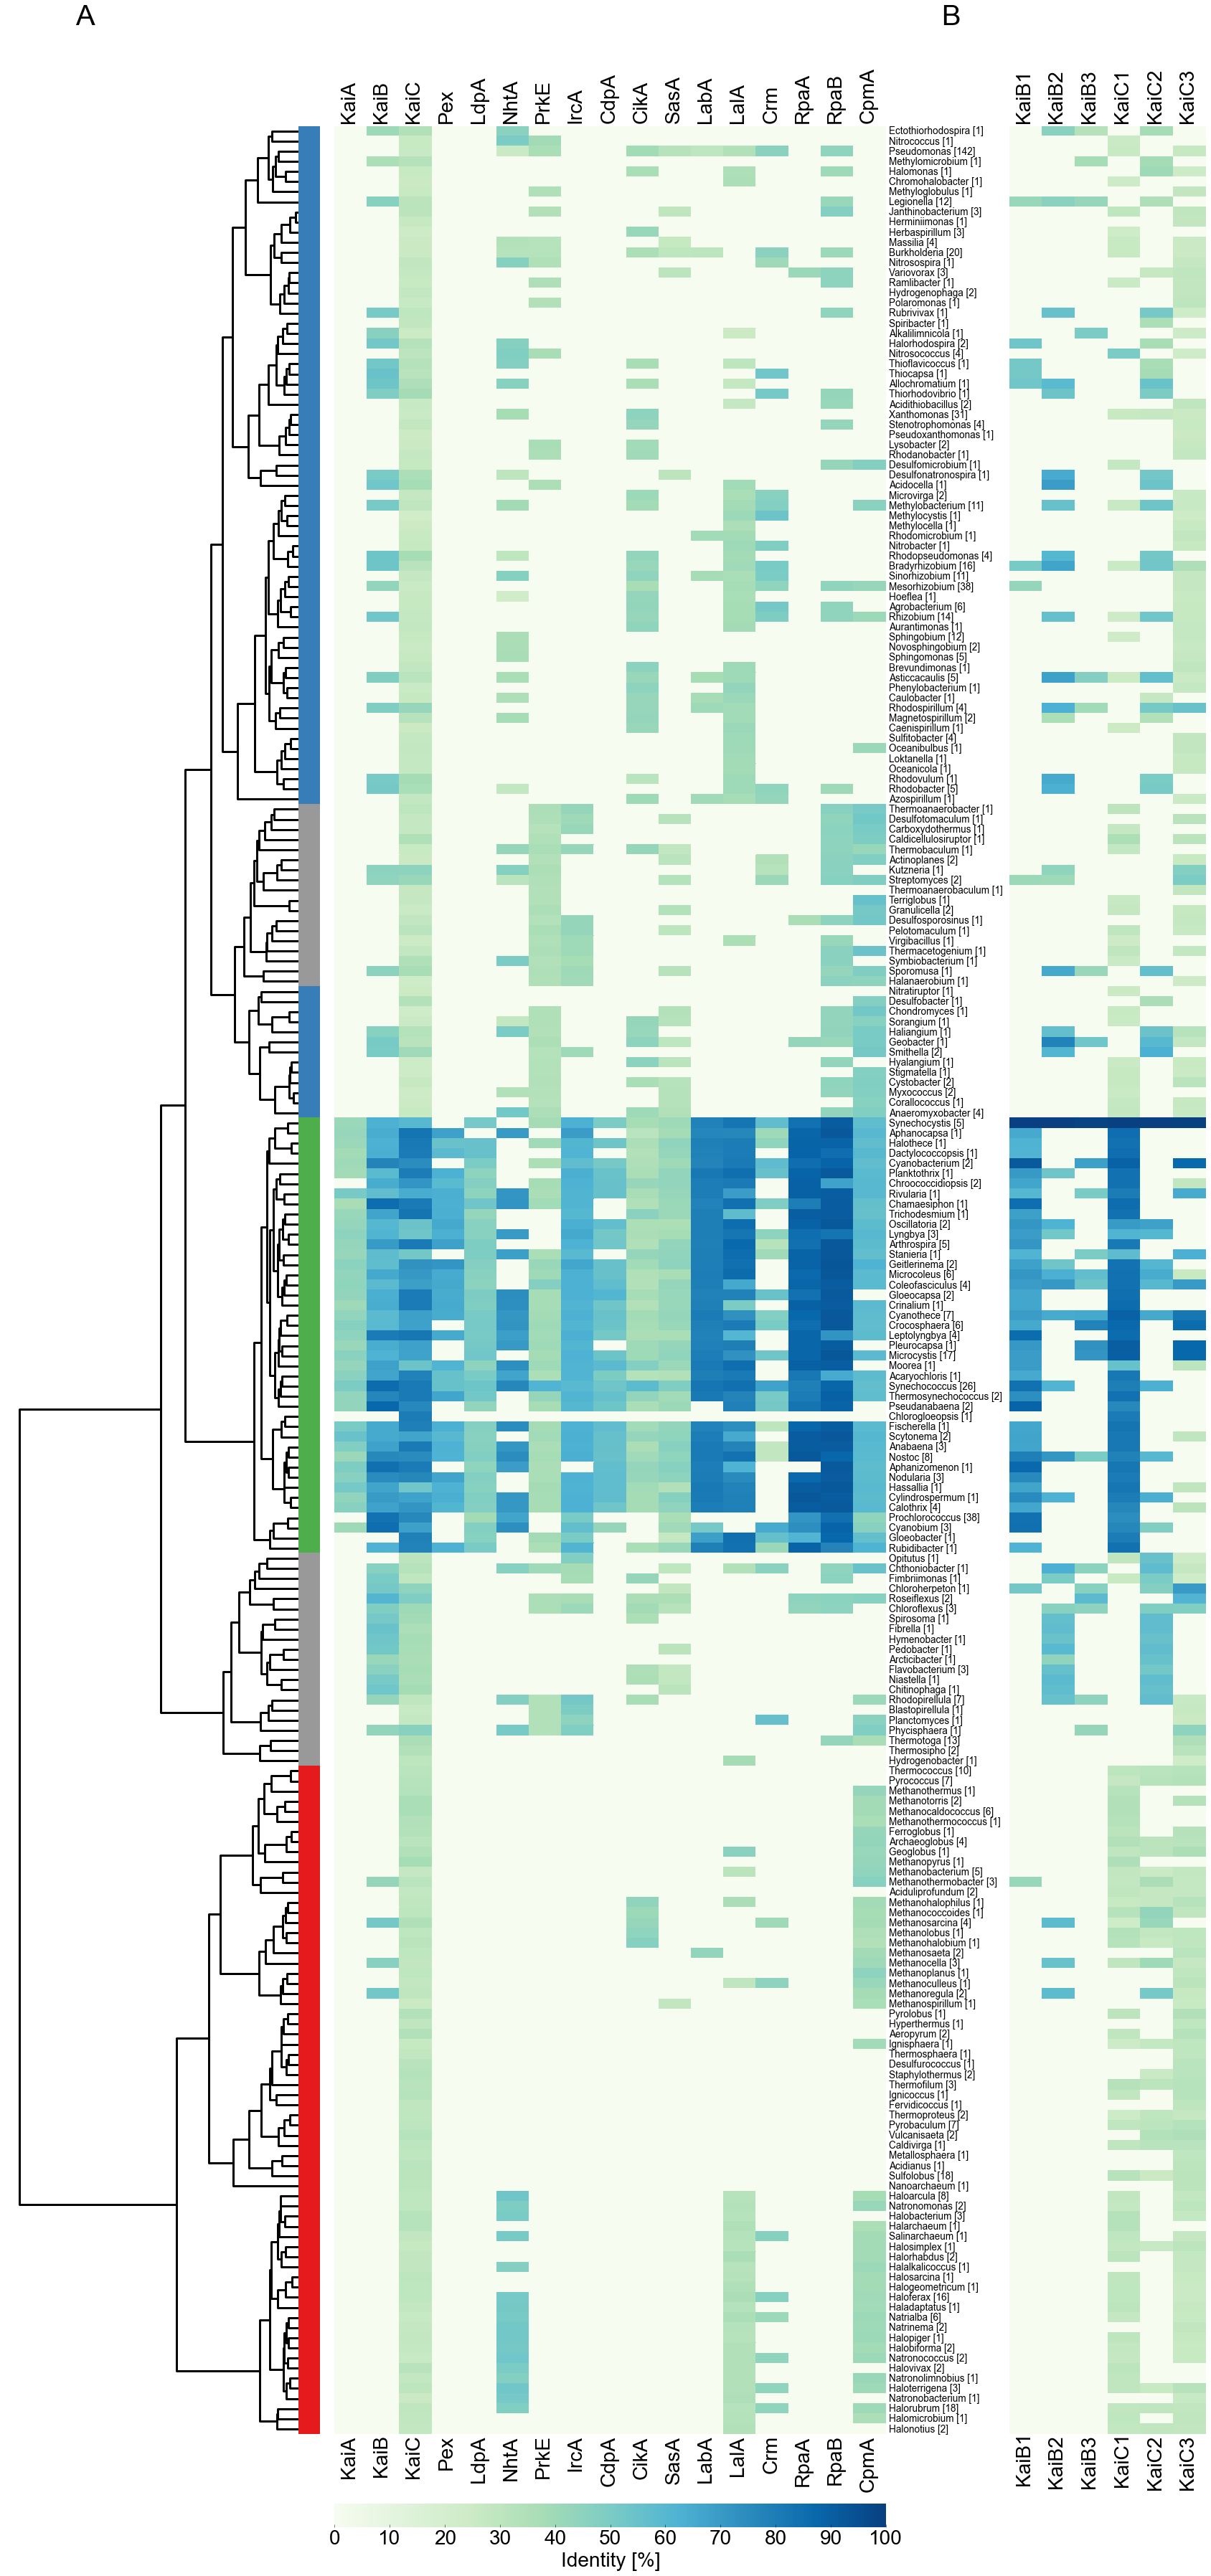

In [20]:
heatmap_phylo(df_Sy7942,df_Sy6803,'heatmap_w_phylo.png')

[Back to Heatmap](#heatmap)

<a id='w/o'></a>
-----
---

__Heatmap without Phylogeny__

---

In [21]:
# The function takes to dataframes and a file name and creates a heatmap and saves it.
def heatmap(df1,df2,name):
    
    f = plt.figure(figsize=(30,60))
    
    plots = gridspec.GridSpec(2,4,wspace=0.05,hspace=0.06,width_ratios=[2,3.5,0.6,1.25],
                              height_ratios=[1,0.01])
    
    hfont = {'fontname':'Arial'}
    
    matplotlib.rcParams['lines.linewidth'] = 3
    
    # Remove the plot frame lines. They are unnecessary chartjunk.
    def clean_axis(ax):
        for sp in ax.spines.values():
            sp.set_visible(False)
    
    ######## 1st Heatmap Synechococcus
    
    ax1 = f.add_subplot(plots[0,1])

    clean_axis(ax1)
    
    # Remove the tick marks; they are unnecessary with the tick lines we just plotted.  
    plt.tick_params(axis="both", which="both", bottom="off", top="off",
                    left="off", right="off", labeltop="on", labelbottom="on", 
                    labelleft="off", labelright="on")

    # Put the major ticks at the middle of each cell
    ax1.set_xticks(np.arange(df1.shape[1])+0.5, minor=False)
    ax1.set_yticks(np.arange(df1.shape[0])+0.5, minor=False)
    
    # Add axis labels
    ax1.set_xticklabels(['KaiA','KaiB','KaiC','Pex','LdpA','NhtA','PrkE','IrcA','CdpA','CikA','SasA','LabA','LalA','Crm','RpaA','RpaB','CpmA'],
                        fontsize=28, rotation=90, **hfont)
    
    # Create a list with y-labels. Each y-label should contain the genus name and the number of underlying organisms.
    ylabels = []
    
    for names, counts in zip(list(df1.query_organism),list(df1.kaiC_count)):
        ylabels.append(str(names)+' ['+str(int(counts))+']')
    
    ax1.set_yticklabels(ylabels, fontsize=13.5, **hfont)

    # Limit the range of the plot to only where the data is.  
    # Avoid unnecessary whitespace.
    plt.ylim(plt.ylim(0, len(df1.index))[::-1]) 

    # Let's do the actual ploting
    heatmapSy = plt.pcolor(df1.iloc[:,4:-1], cmap='GnBu',vmin=0, vmax=100)
    
    ######## Phylogeny
    PhyloTax = gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec=plots[0,0],
                                                wspace=0,hspace=0,width_ratios=[10,0.75])
    
    ax = f.add_subplot(PhyloTax[0,0])
    
    # Remove the tick marks; they are unnecessary with the tick lines we just plotted.  
    plt.tick_params(axis="both", which="both", bottom="off", top="off",
                    left="off", right="off", labeltop="on", labelbottom="on", 
                    labelleft="off", labelright="off")
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    clean_axis(ax)

    ######## Taxonomy 4 Groups (Cyanobacteria, Proteobacteria, Archaea, Other)
    
    ax0 = f.add_subplot(PhyloTax[0,1], sharey=ax1) 

    # Remove the tick marks; they are unnecessary with the tick lines we just plotted.  
    plt.tick_params(axis="both", which="both", bottom="off", top="off",
                    left="off", right="off", labeltop="off", labelbottom="off", 
                    labelleft="off", labelright="off")
    
    clean_axis(ax0)
    
    # Create a colored bar that corresponds to the four groups.
    heatmap_taxo = plt.pcolor(df1.iloc[:,2:3], cmap='Set1',vmin=1, vmax=9)
    
    ######## Colorbar
    
    ax3 = f.add_subplot(plots[1,1])
    
    # Modify colorbar
    cbar = f.colorbar(heatmapSy, ax3,orientation='horizontal')
    
    tick_locator = ticker.MaxNLocator(nbins=11)
    cbar.locator = tick_locator
    
    cbar.update_ticks() 
    
    # Set labels and tick labels
    cbar.ax.set_xticklabels(np.arange(0,101,10), fontsize=28, **hfont)
    cbar.set_label('Identity [%]', fontsize=28, **hfont)

    cbar.outline.set_linewidth(0)

    ######## 2nd Heatmap KaiBC123
    
    ax2 = f.add_subplot(plots[0,3], sharey=ax1)

    clean_axis(ax2)

    # Put the major ticks at the middle of each cell
    ax2.set_xticks(np.arange(df2.shape[1])+0.5, minor=False)
    
    # Remove the tick marks; they are unnecessary with the tick lines we just plotted.  
    plt.tick_params(axis="both", which="both", bottom="off", top="off",
                    left="off", right="off", labeltop="on", labelbottom="on", 
                    labelleft="off", labelright="off")
    
    # Add axis labels
    ax2.set_xticklabels(['KaiB1','KaiB2','KaiB3','KaiC1','KaiC2','KaiC3'],
                        fontsize=28, rotation=90, **hfont)    

    # Let's do the actual ploting
    heatmapBC = plt.pcolor(df2.iloc[:,4:], cmap='GnBu',vmin=0, vmax=100) 
    
    ######## Add some text
    
    ax1.text(-2,-10,'A',fontsize=40, **hfont)
    ax2.text(-2,-10,'B',fontsize=40, **hfont)

    #plt.savefig(name, format='png',dpi=500)
    plt.show()

In [22]:
# Sort dataframe first by the four assigned groups and then by the KaiC identity
df_Sy7942_sorted = df_Sy7942.sort(['taxonomy','kaiC_identity'], ascending=[True,False])

sorterIndex = dict(zip(df_Sy7942_sorted.query_organism,range(len(df_Sy7942_sorted.query_organism))))

# Use this order to sort the other dataframe
df_Sy6803_sorted = df_Sy6803.copy()
df_Sy6803_sorted['rank'] = df_Sy6803_sorted.query_organism.map(sorterIndex)

df_Sy6803_sorted = df_Sy6803_sorted.sort(['rank'], ascending = [True])

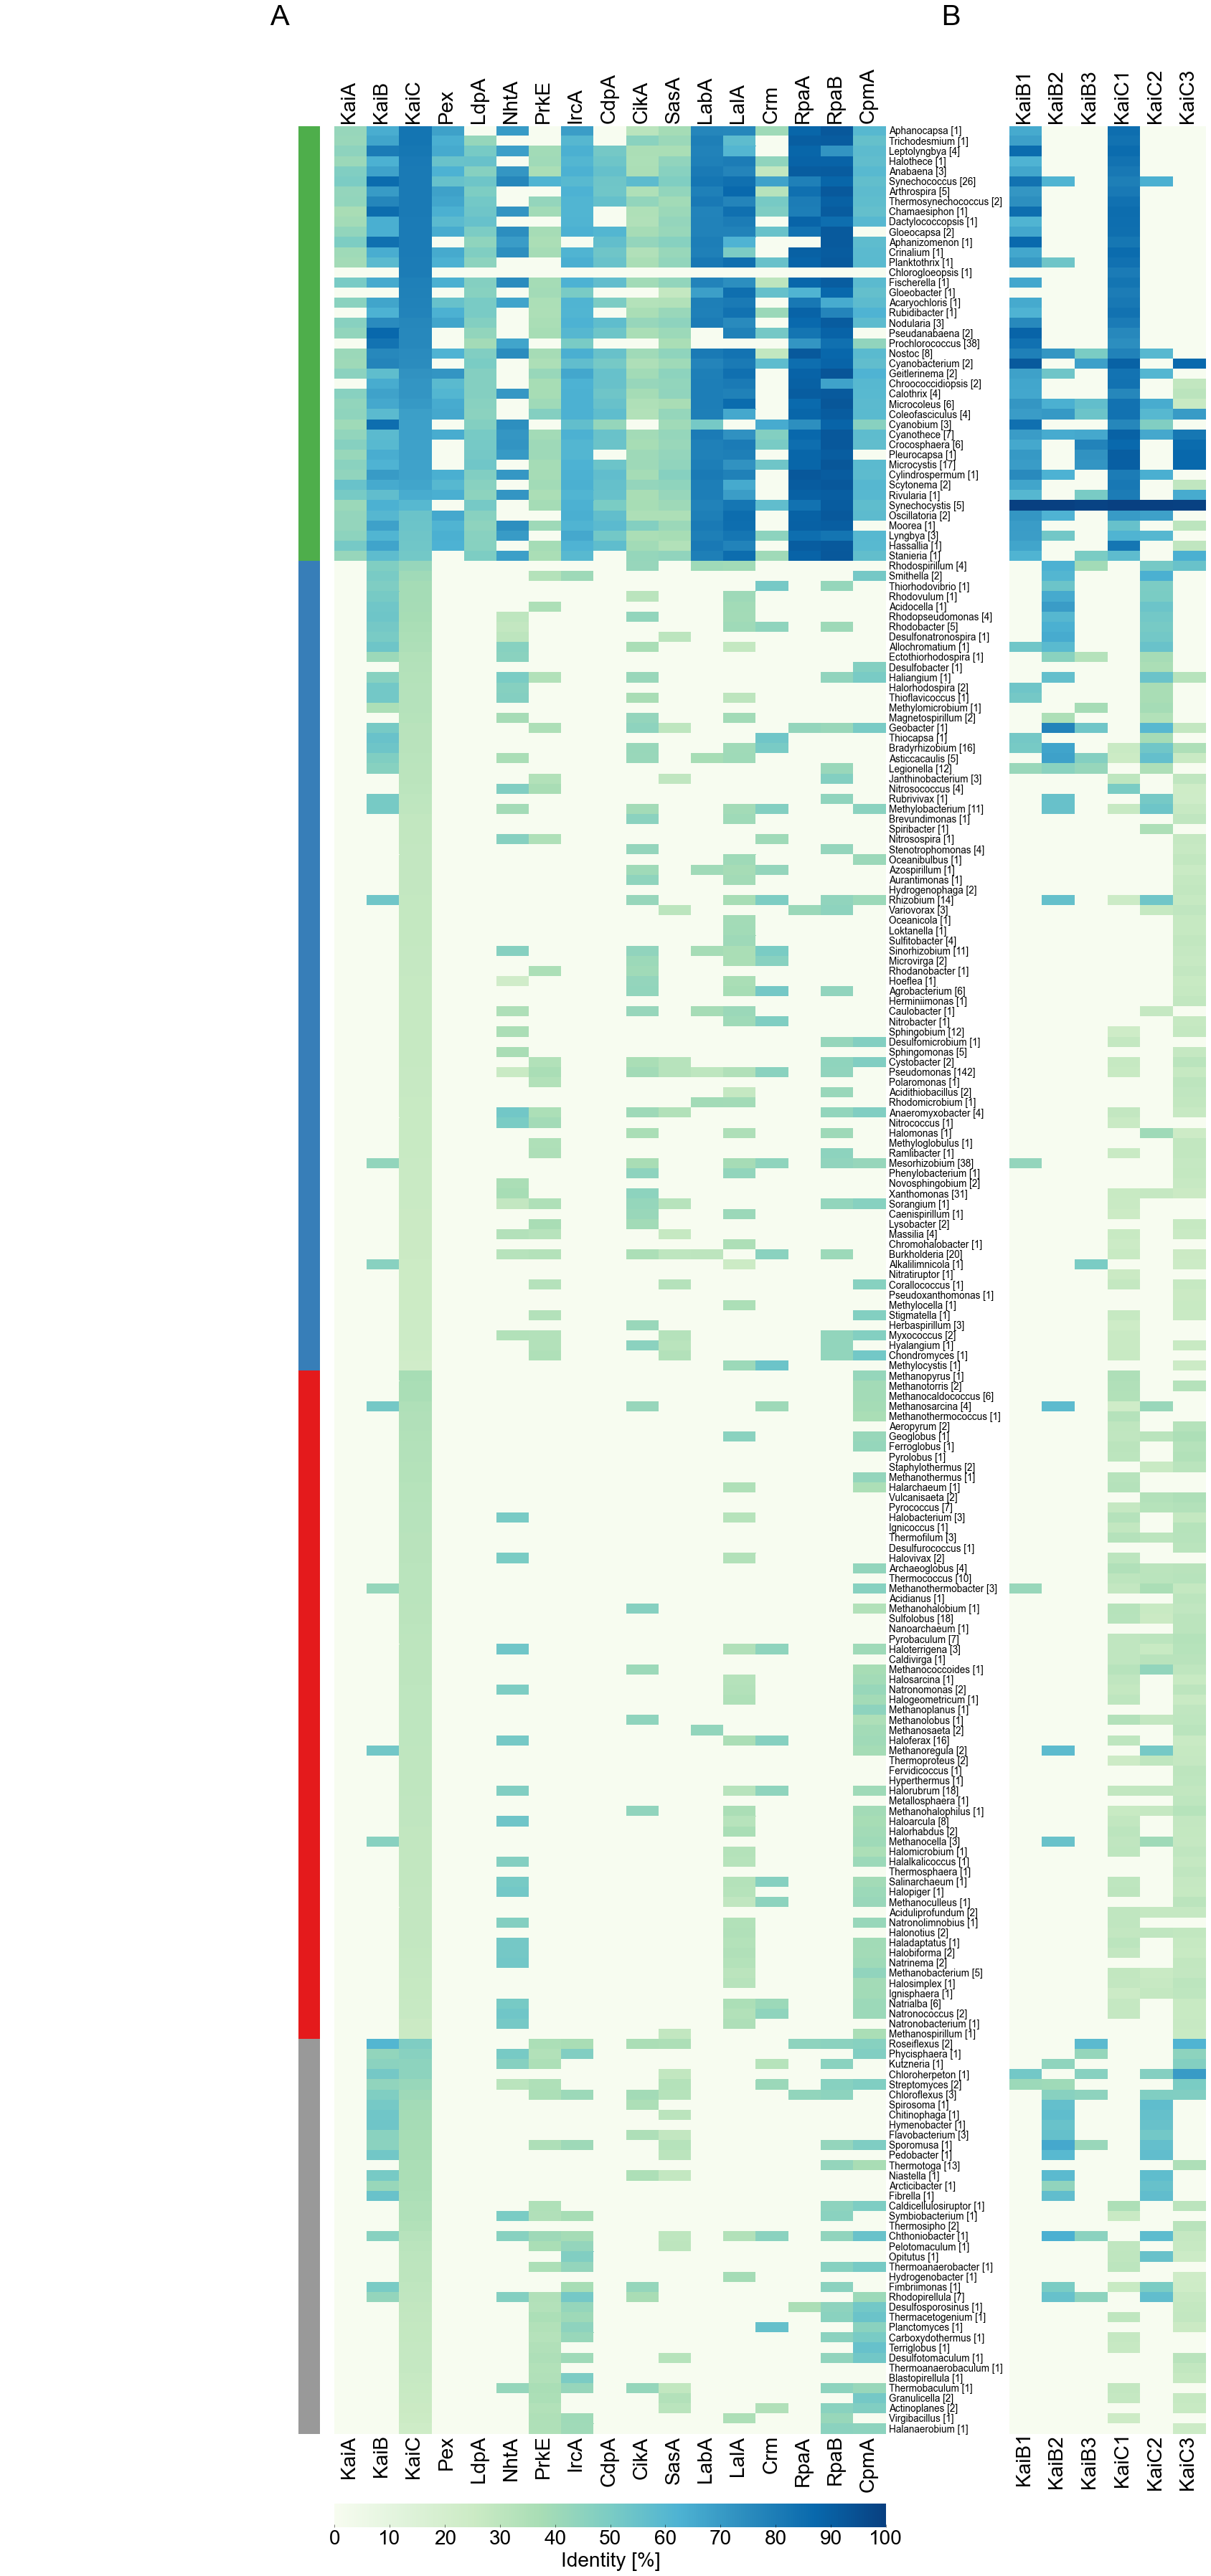

In [23]:
heatmap(df_Sy7942_sorted,df_Sy6803_sorted,'heatmap_wo_phylo.png')

[Back to Heatmap](#heatmap)

<a id='cyano'></a>
-----
---

__Heatmap containing only cyanobacteria__

---

In [24]:
# The function takes to dataframes and a file name and creates a heatmap and saves it.
def heatmap_cyano(df1,df2,name):
    
    f = plt.figure(figsize=(30,30))
    
    plots = gridspec.GridSpec(3,3,wspace=0.05,hspace=0.06,width_ratios=[3.5,1.1,1.25],
                              height_ratios=[1,0.03,0.03])
    
    hfont = {'fontname':'Arial'}
    
    matplotlib.rcParams['lines.linewidth'] = 3
    
    # Remove the plot frame lines. They are unnecessary chartjunk.
    def clean_axis(ax):
        for sp in ax.spines.values():
            sp.set_visible(False)
    
    ######## 1st Heatmap Synechococcus
    
    ax1 = f.add_subplot(plots[0,0])

    clean_axis(ax1)
    
    # Remove the tick marks; they are unnecessary with the tick lines we just plotted.  
    plt.tick_params(axis="both", which="both", bottom="off", top="off",
                    left="off", right="off", labeltop="on", labelbottom="on", 
                    labelleft="off", labelright="on")

    # Put the major ticks at the middle of each cell
    ax1.set_xticks(np.arange(df1.shape[1])+0.5, minor=False)
    ax1.set_yticks(np.arange(df1.shape[0])+0.5, minor=False)
    
    # Add axis labels
    ax1.set_xticklabels(['KaiA','KaiB','KaiC','Pex','LdpA','NhtA','PrkE','IrcA','CdpA','CikA','SasA','LabA','LalA','Crm','RpaA','RpaB','CpmA'],
                        fontsize=28, rotation=90, **hfont)
    
    # Create a list with y-labels. Each y-label should contain the genus name and the number of underlying organisms.
    ylabels = []
    
    for names, counts in zip(list(df1.query_organism),list(df1.kaiC_count)):
        ylabels.append(str(names)+' ['+str(int(counts))+']')
    
    ax1.set_yticklabels(ylabels, fontsize=28, **hfont)

    # Limit the range of the plot to only where the data is.  
    # Avoid unnecessary whitespace.
    plt.ylim(plt.ylim(0, len(df1.index))[::-1]) 

    # Let's do the actual ploting
    heatmapSy = plt.pcolor(df1.iloc[:,4:-1], cmap='GnBu',vmin=0, vmax=100)
    
    ######## Colorbar
    
    ax3 = f.add_subplot(plots[2,0])
    
    # Modify colorbar
    cbar = f.colorbar(heatmapSy, ax3,orientation='horizontal')
    
    tick_locator = ticker.MaxNLocator(nbins=11)
    cbar.locator = tick_locator
    
    cbar.update_ticks() 
    
    # Set labels and tick labels
    cbar.ax.set_xticklabels(np.arange(0,101,10), fontsize=35, **hfont)
    cbar.set_label('Identity [%]', fontsize=35, **hfont)

    cbar.outline.set_linewidth(0)

    ######## 2nd Heatmap KaiBC123
    
    ax2 = f.add_subplot(plots[0,2], sharey=ax1)

    clean_axis(ax2)

    # Put the major ticks at the middle of each cell
    ax2.set_xticks(np.arange(df2.shape[1])+0.5, minor=False)
    
    # Remove the tick marks; they are unnecessary with the tick lines we just plotted.  
    plt.tick_params(axis="both", which="both", bottom="off", top="off",
                    left="off", right="off", labeltop="on", labelbottom="on", 
                    labelleft="off", labelright="off")
    
    # Add axis labels
    ax2.set_xticklabels(['KaiB1','KaiB2','KaiB3','KaiC1','KaiC2','KaiC3'],
                        fontsize=35, rotation=90, **hfont)    

    # Let's do the actual ploting
    heatmapBC = plt.pcolor(df2.iloc[:,4:], cmap='GnBu',vmin=0, vmax=100) 
    
    ######## Add some text
    
    ax1.text(-2,-4,'A',fontsize=50, **hfont)
    ax2.text(-2,-4,'B',fontsize=50, **hfont)

    #plt.savefig(name, format='png',dpi=500)
    plt.show()

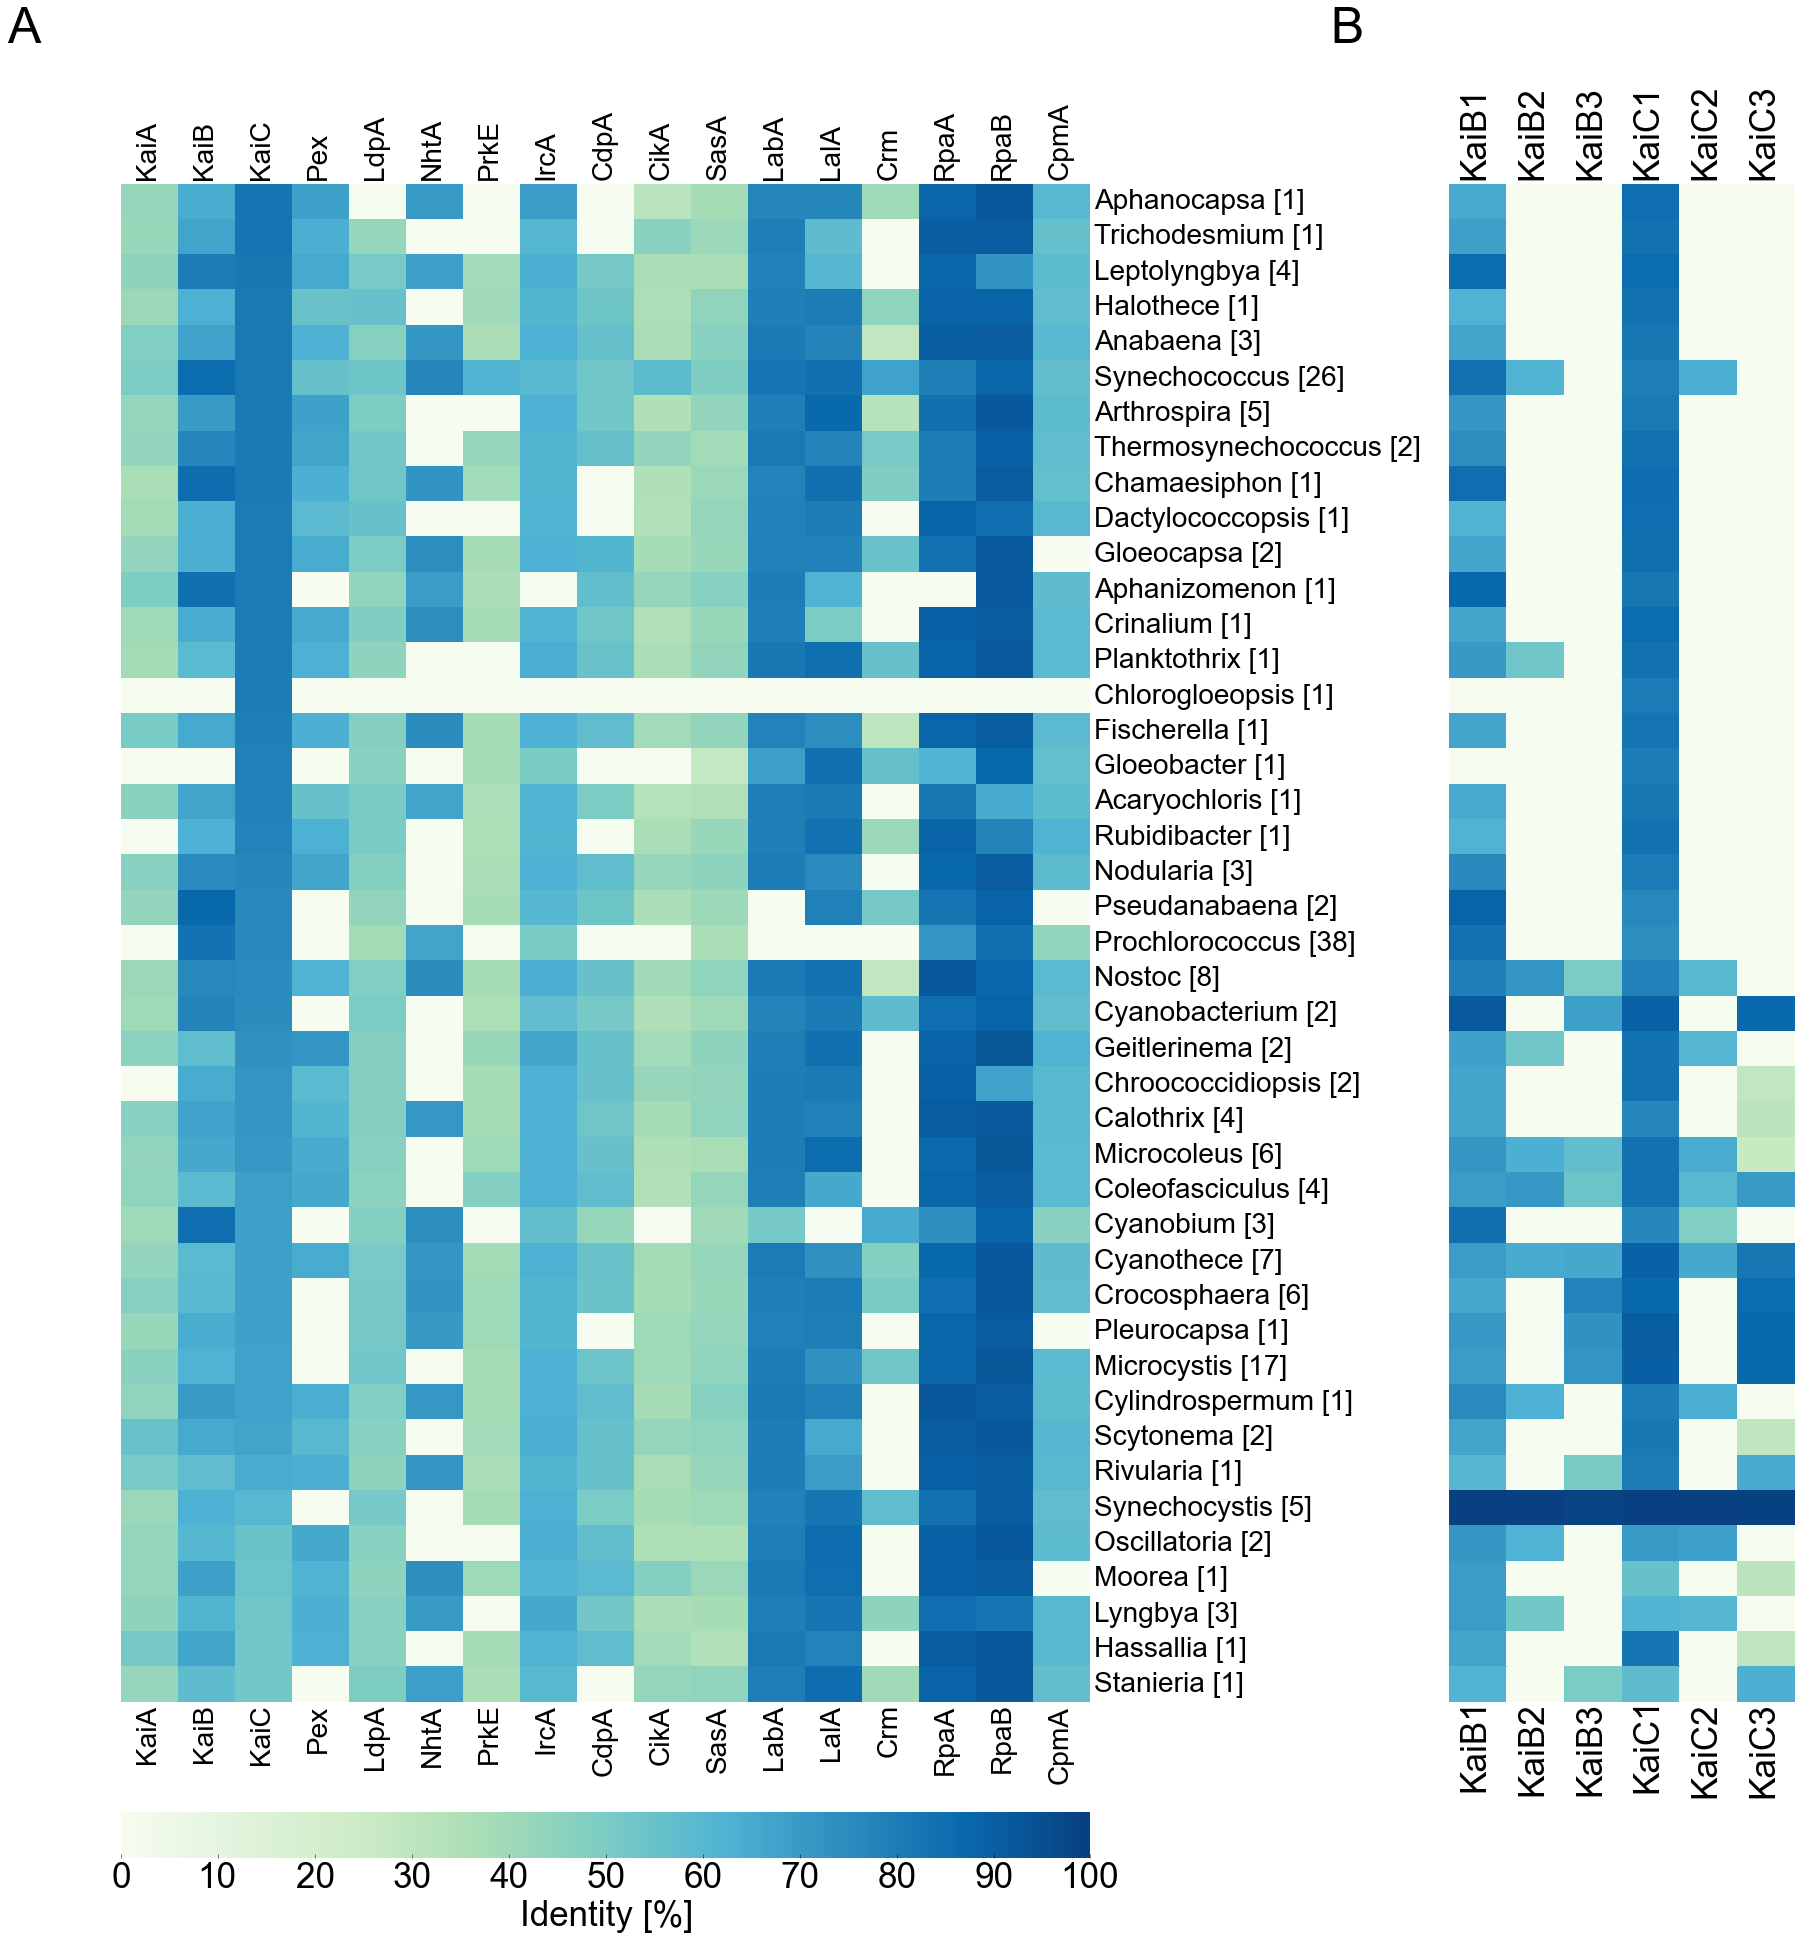

In [25]:
heatmap_cyano(df_Sy7942_sorted[df_Sy7942_sorted.taxonomy == 1], df_Sy6803_sorted[df_Sy6803_sorted.taxonomy == 1],
              'heatmap_cyano_only.png')

[Back to Content](#Content)

<a id='cyano_count'></a>
-----

---
###Heatmap with number of circadian clock protein copies###

---

The dataframes, containing the identity information to the circadian clock proteins of _Synechococcus elongatus_ PCC 7942, and the KaiBC homolog of Synechocystis sp. PCC 6803, can be used to create a dataframe containing the numbers of copies to each circadian clock protein for each organism.

In [26]:
kaiA = pd.read_csv('1._BLAST/Synechococcus/kaiA_all.csv')
kaiA = categories_taxonomy(kaiA)
kaiA = kaiA[kaiA.taxonomy == 1]
kaiA = kaiA[['query_name','kaiA_length']]
kaiA = kaiA[kaiA.kaiA_length > 0].drop_duplicates()
kaiA['kaiA_count'] = kaiA.groupby(['query_name']).transform('count')
kaiA = kaiA[['query_name','kaiA_count']].drop_duplicates()

In [27]:
cyano_df = kaiA.copy()

In [28]:
# Prepare the dataframe for the protein copy count. First KaiA, KaiB1 and KaiC1. Then add the other Kai proteins from
# Synechocystis and the rest from Synechococcus. 
protein_list = ['kaiB1','kaiC1','kaiB2','kaiC2','kaiB3','kaiC3','pex','ldpA','nhtA','prkE',
                'ircA','cdpA','cikA','sasA','labA','lalA','crm','rpaA','rpaB','cpmA']

for protein in protein_list[:2]:
    cyano_df = create_count_df('1._BLAST/Synechocystis/%s_all.csv' %protein,
                                protein, cyano_df, how='outer')
    
for protein in protein_list[2:6]:
    cyano_df = create_count_df('1._BLAST/Synechocystis/%s_all.csv' %protein,
                                protein, cyano_df, how='left')
    
for protein in protein_list[6:]:
    cyano_df = create_count_df('1._BLAST/Synechococcus/%s_all.csv' %protein,
                                protein, cyano_df, how='left')

In [29]:
t_abc = cyano_df.copy()

t_abc = t_abc[t_abc.query_name != 'Gloeobacter violaceus PCC 7421']

#### Manually curated ####

t_abc.kaiA_count[cyano_df.query_name == 'Acaryochloris marina MBIC11017'] = 1
t_abc.kaiA_count[cyano_df.query_name == 'Synechococcus sp. PCC 7002'] = 1
t_abc.kaiA_count[cyano_df.query_name == 'Synechococcus sp. WH 8109'] = 1
t_abc.kaiA_count[cyano_df.query_name == 'Chroococcidiopsis thermalis PCC 7203'] = 1
t_abc.kaiA_count[cyano_df.query_name == 'Gloeocapsa sp. PCC 7428'] = 1

t_abc.kaiB1_count[cyano_df.query_name == 'Cylindrospermum stagnale PCC 7417'] = 2

t_abc.kaiC1_count[cyano_df.query_name == 'Cylindrospermum stagnale PCC 7417'] = 1
t_abc.kaiC1_count[cyano_df.query_name == 'Xenococcus sp. PCC 7305'] = 1
t_abc.kaiC1_count[cyano_df.query_name == 'Chroococcidiopsis thermalis PCC 7203'] = 1

t_abc.cpmA_count[cyano_df.query_name == 'Chroococcidiopsis thermalis PCC 7203'] = 1
t_abc.nhtA_count[cyano_df.query_name == 'Nostoc sp. PCC 7120'] = 1

##########################

t_abc = t_abc.sort(['kaiA_count','kaiB1_count','kaiC1_count','kaiB3_count','kaiC3_count',
                    'kaiB2_count','kaiC2_count','pex_count','ldpA_count','nhtA_count',
                    'prkE_count','ircA_count','cdpA_count','cikA_count','sasA_count',
                    'labA_count','lalA_count','crm_count','rpaA_count','rpaB_count',
                    'cpmA_count'],
                   ascending=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

# Keep only those cyanobacteria with more than 5 circadian clock protein homologs
t_abc = t_abc[t_abc.sum(axis=1) > 5]

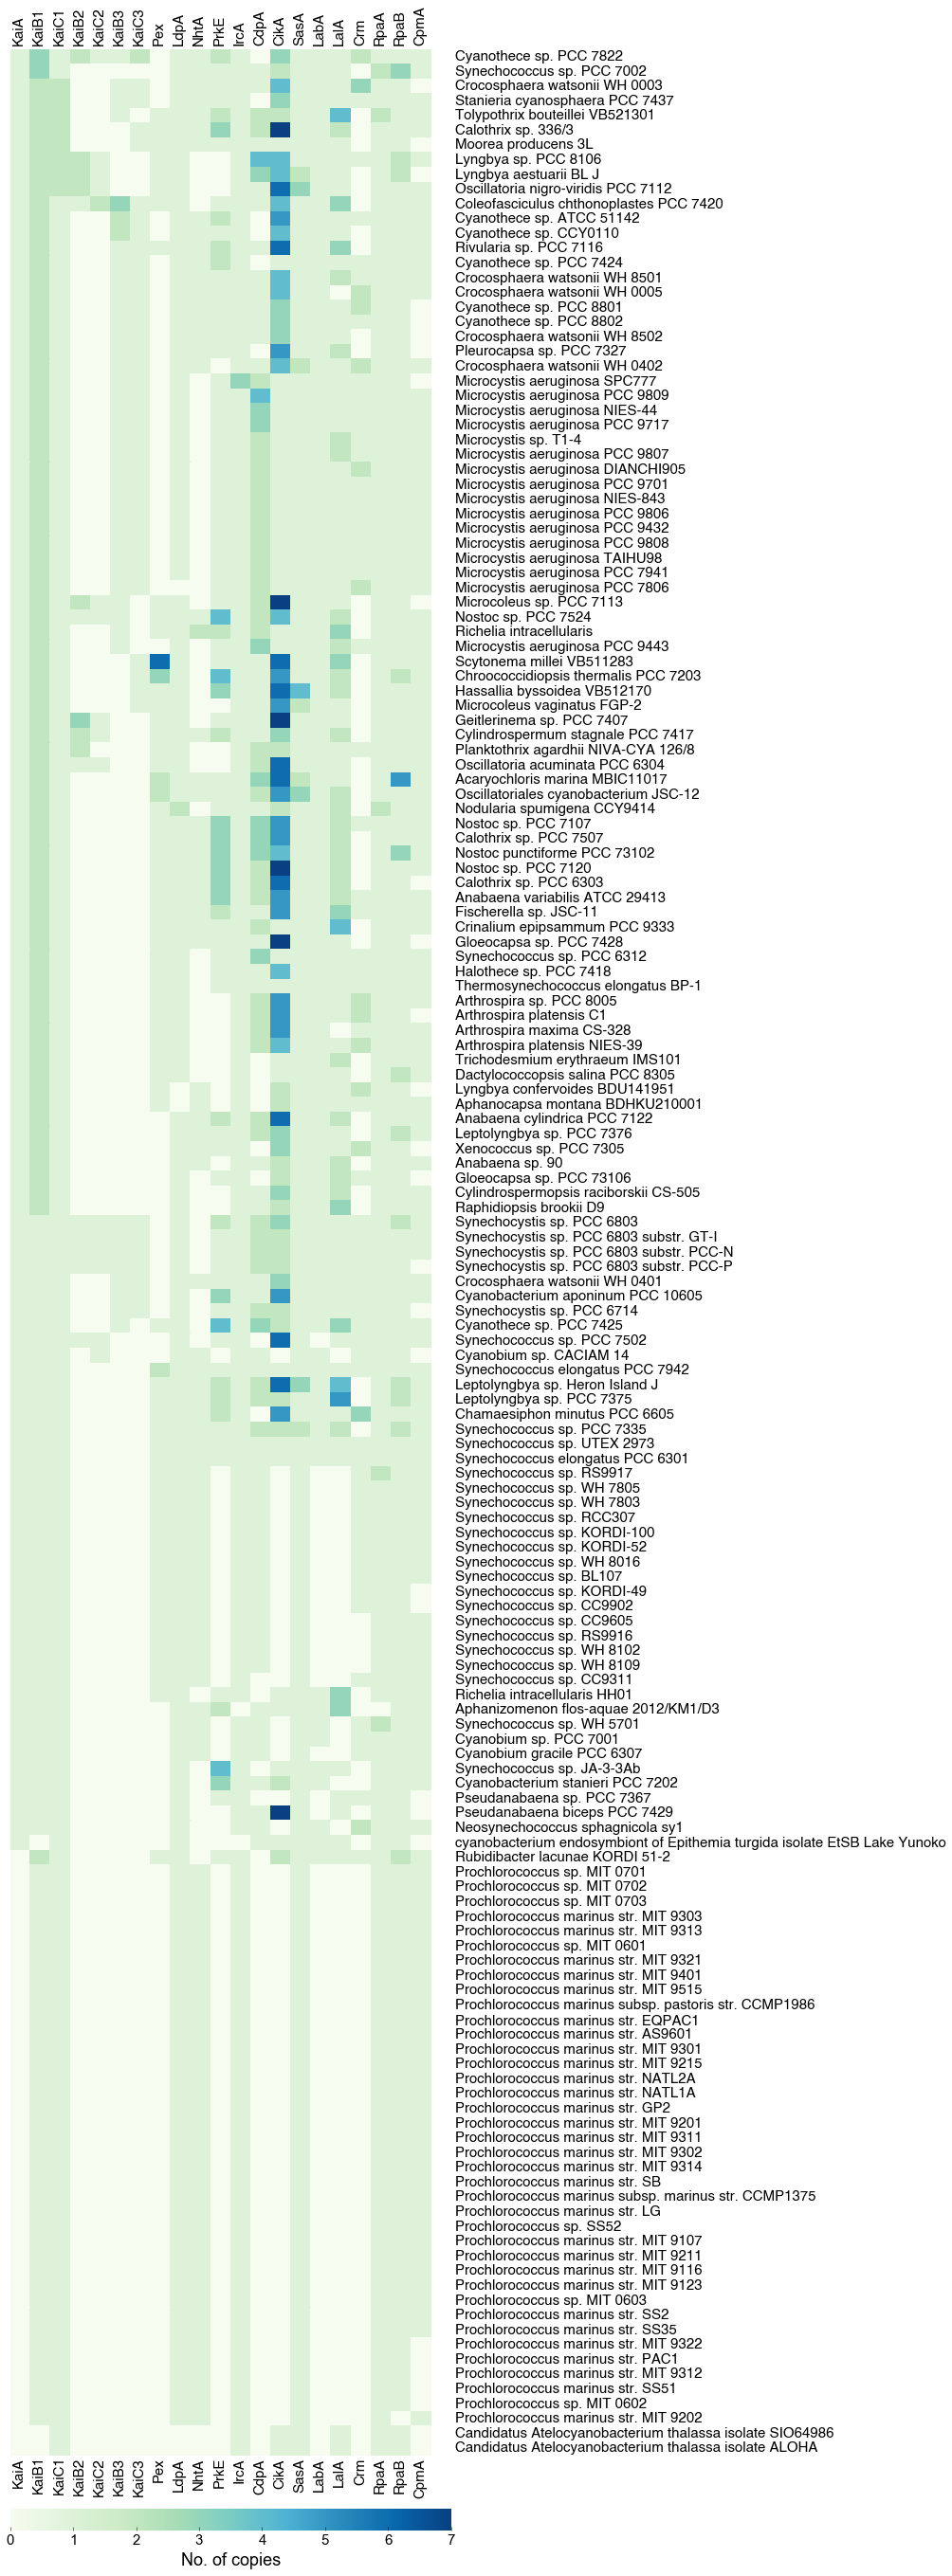

In [35]:
f = plt.figure(figsize=(20,50)) 

plots = gridspec.GridSpec(1,2,wspace=0.0,hspace=0.0, width_ratios=[2.5,3.5])

def clean_axis(ax):
    """Remove ticks, tick labels, and frame from axis"""
    for sp in ax.spines.values():
        sp.set_visible(False)
        
hfont = {'fontname':'Arial'}
    
########
    
ax1 = f.add_subplot(plots[0,0])

clean_axis(ax1)

xlim(0, 22)
ylim(0, len(t_abc.index))

plt.tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="off", right="off", labelleft='off',
                labelright='on', labeltop="on")

ax1.set_xticks(np.arange(len(t_abc.columns[1:]))+0.5, minor=False)
ax1.set_yticks(np.arange(len(t_abc.index))+0.5, minor=False)

PCC7942 = ['KaiA','KaiB1','KaiC1','KaiB2','KaiC2','KaiB3','KaiC3','Pex','LdpA','NhtA','PrkE',
           'IrcA','CdpA','CikA','SasA','LabA','LalA','Crm','RpaA','RpaB','CpmA','Crr37']


ax1.set_xticklabels(PCC7942, fontsize=15, rotation=90)
ax1.set_yticklabels(list(t_abc.query_name), fontsize=15, rotation=0)

heatmap = plt.pcolor(t_abc.iloc[:,1:], cmap='GnBu', vmax=7, vmin=0)

cbar = f.colorbar(heatmap, orientation='horizontal', pad=0.02, fraction=0.07)

tick_locator = ticker.MaxNLocator(nbins=8)
cbar.locator = tick_locator
    
cbar.update_ticks() 
    
cbar.ax.set_xticklabels(np.arange(0,8,1), fontsize=15, **hfont)
    
cbar.set_label('No. of copies', fontsize=18, **hfont)
cbar.outline.set_linewidth(0)

ax1.invert_yaxis()

#plt.savefig('prot_count.png', dpi=500)

---
###Previous###

+ [Data Collection and Processing](1_KaiABC_BLAST_DataCollectionProcessing.ipynb)
+ [Impact of filtering on the number of hits](2_KaiABC_BLAST_BarChart.ipynb)

###Next###

+ [Length distribution of KaiA, KaiB, KaiC](4_KaiABC_BLAST_Scatterplot.ipynb)
+ [Co-occurence of circadian clock proteins in cyanobacteria](5_KaiABC_BLAST_FisherTest.ipynb)

---